# Librerias

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Imagen

In [6]:
pre_path = "../../../../../data/images/"
t2_path = pre_path + "10029/10029_1000029_t2w.mha"
adc_path = pre_path + "10029/10029_1000029_adc.mha"
dwi_path = pre_path + "10029/10029_1000029_hbv.mha"

In [7]:
t2_image = sitk.ReadImage(t2_path)
adc_image = sitk.ReadImage(adc_path)
dwi_image = sitk.ReadImage(dwi_path)

# Visualización

In [5]:
def visualize_image(image):
    fig, axes = plt.subplots (nrows = 2, ncols = 3, figsize = (10, 10))
    rect = fig.patch
    rect.set_facecolor('black')
    
    axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
    axes[0,1].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
    axes[0,2].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
    axes[1,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
    axes[1,1].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
    axes[1,2].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
    
    for ax in axes.flat:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(h_pad=-15, w_pad=1)

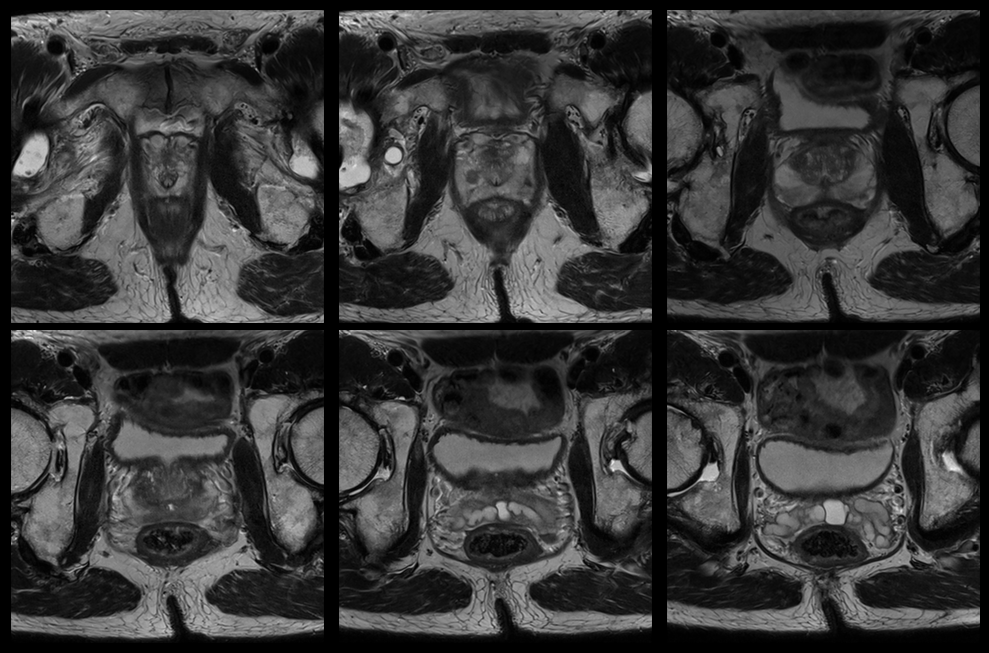

In [8]:
visualize_image(t2_image)

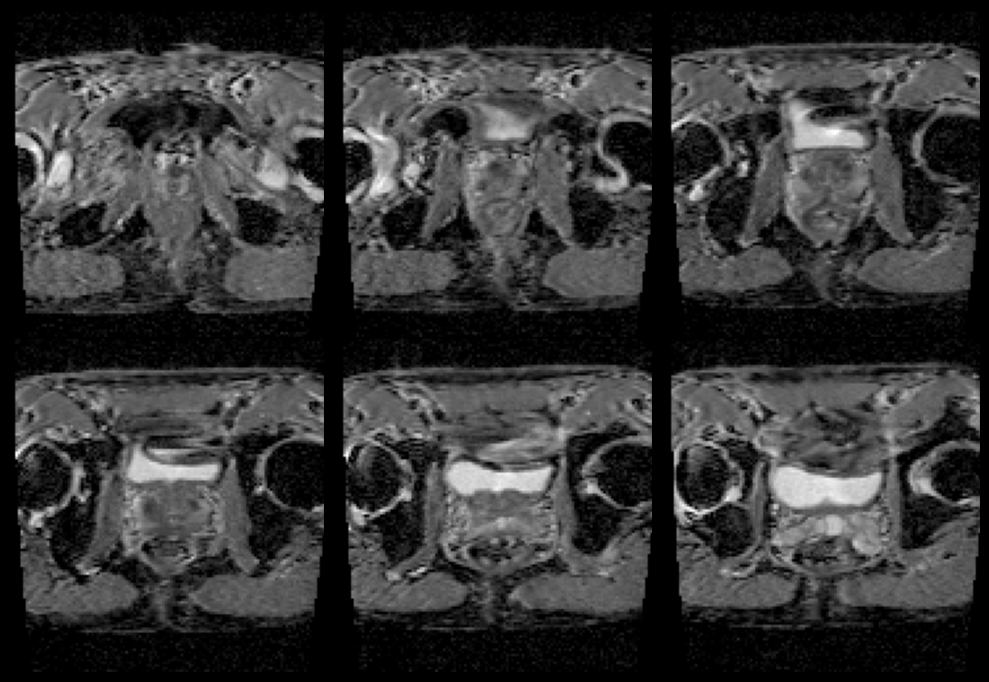

In [9]:
visualize_image(adc_image)

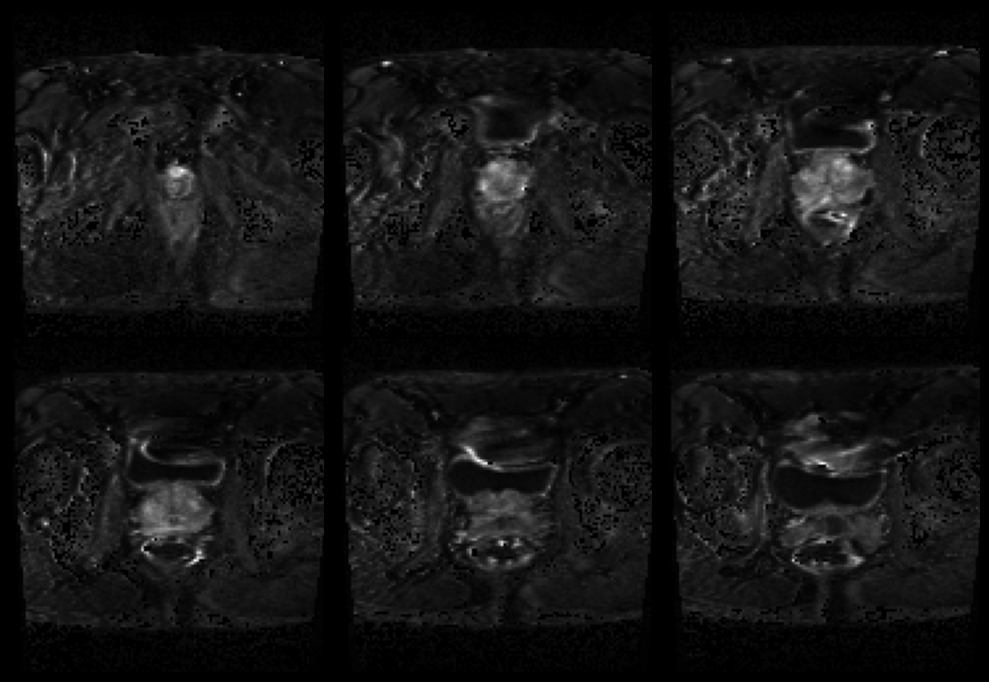

In [10]:
visualize_image(dwi_image)

# Create copy of image in float 32-bits

In [34]:
print(t2_image.GetPixelIDTypeAsString())
print(adc_image.GetPixelIDTypeAsString())
print(dwi_image.GetPixelIDTypeAsString())

16-bit unsigned integer
16-bit unsigned integer
16-bit unsigned integer


In [15]:
t2_image_float32 = sitk.Cast(t2_image, sitk.sitkFloat32)
adc_image_float32 = sitk.Cast(adc_image, sitk.sitkFloat32)
dwi_image_float32 = sitk.Cast(dwi_image, sitk.sitkFloat32)

In [35]:
def plot_comparison(image1, image2, title1='Original MRI', title2='Imagen 2'):
    image1_arr = sitk.GetArrayFromImage(image1)
    image2_arr = sitk.GetArrayFromImage(image2)
    
    slice_indices = [3, 5, 8, 10, 12, 14]
    
    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 10))
    fig.patch.set_facecolor('black')
    
    for row, idx in enumerate(slice_indices):
        axes[row, 0].imshow(image1_arr[idx, :, :], cmap='gray')
        axes[row, 0].set_title(title1, color='w')
        
        axes[row, 1].imshow(image2_arr[idx, :, :], cmap='gray')
        axes[row, 1].set_title(title2, color='w')
        
        diff = image1_arr[idx, :, :] - image2_arr[idx, :, :]
        axes[row, 2].imshow(diff, cmap='gray')
        axes[row, 2].set_title('Difference', color='w')
    
    for ax in axes.flat:
        ax.axis('off')
    
    fig.tight_layout(h_pad=0, w_pad=-15)
    plt.show()

# Bias field inhomogeneities correction

In [16]:
def bias_field_correction(image_float32, shrink_factor=4, control_points=[4, 4, 4]):
    shrinked_image = sitk.Shrink(image_float32, [shrink_factor] * image_float32.GetDimension())
    
    bias_field_filter = sitk.N4BiasFieldCorrectionImageFilter()
    bias_field_filter.SetNumberOfControlPoints(control_points)
    bias_field_filter.UseMaskLabelOff()
    
    _ = bias_field_filter.Execute(shrinked_image)
    
    log_bias_field = bias_field_filter.GetLogBiasFieldAsImage(image_float32)
    
    bias_corrected_image = image_float32 / sitk.Exp(log_bias_field)
    
    return bias_corrected_image

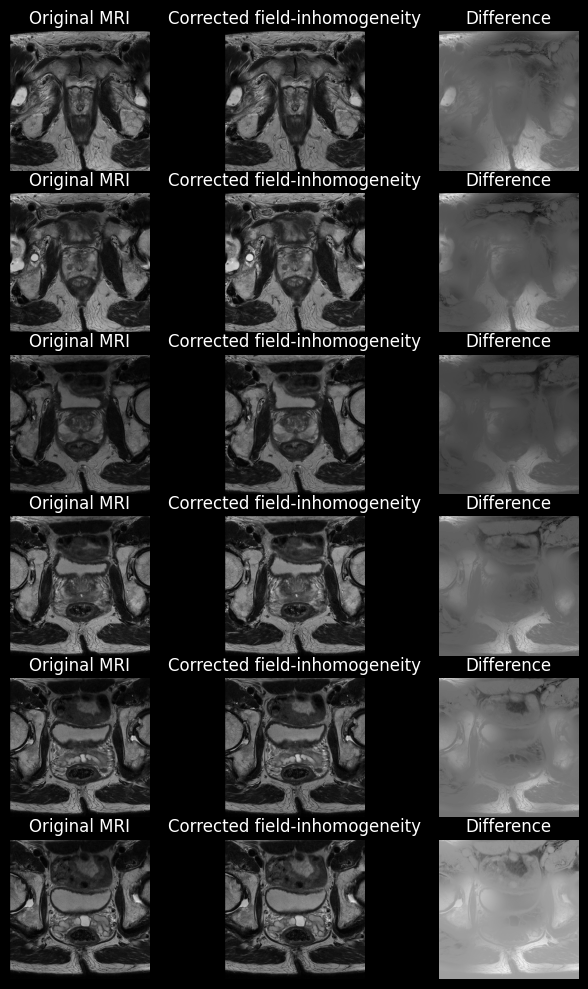

In [25]:
t2_bias_corrected_image = bias_field_correction(t2_image_float32)
plot_comparison(t2_image, t2_bias_corrected_image, title2="Corrected field-inhomogeneity")

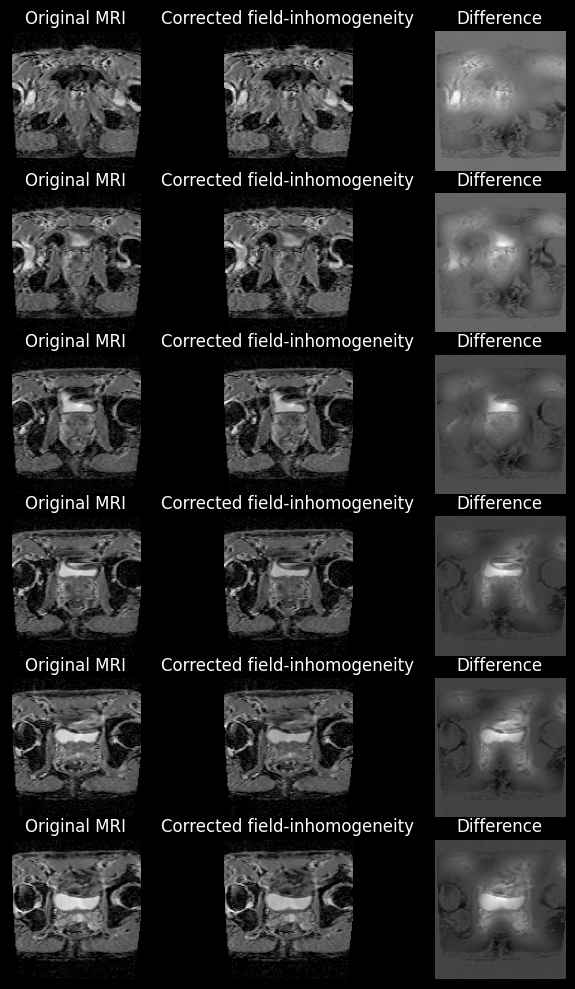

In [26]:
adc_bias_corrected_image = bias_field_correction(adc_image_float32)
plot_comparison(adc_image, adc_bias_corrected_image, title2="Corrected field-inhomogeneity")

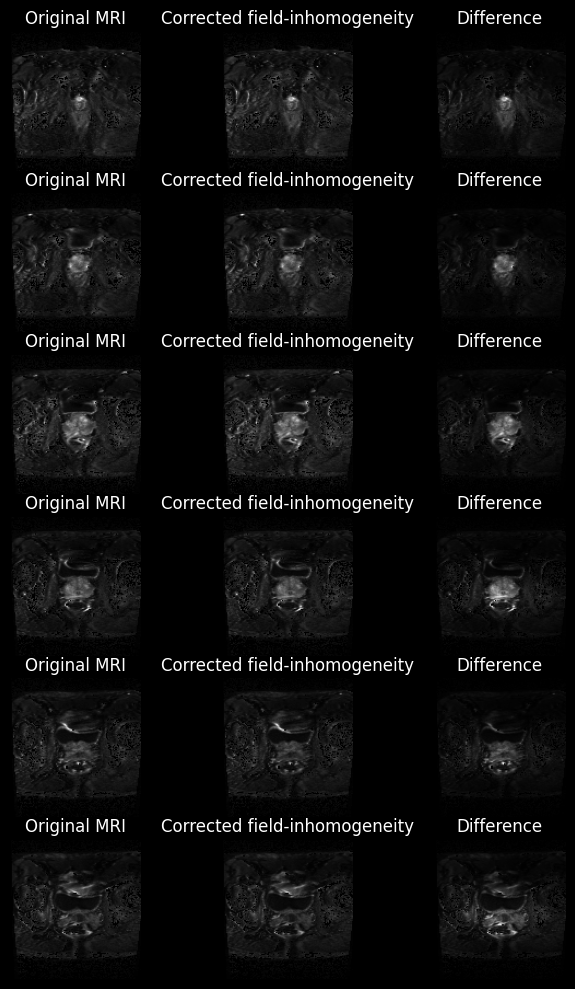

In [27]:
dwi_bias_corrected_image = bias_field_correction(dwi_image_float32)
plot_comparison(dwi_image, dwi_bias_corrected_image, title2="Corrected field-inhomogeneity")

# Denoising MRI

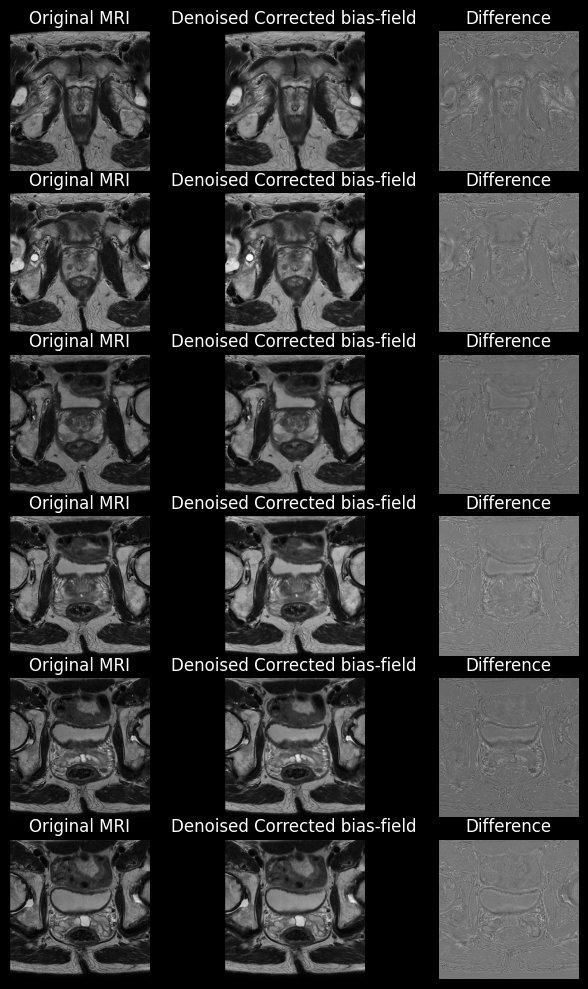

In [31]:
t2_denoised_image = sitk.CurvatureAnisotropicDiffusion(t2_bias_corrected_image, timeStep=0.03125)
plot_comparison(t2_bias_corrected_image, t2_denoised_image, title2="Denoised Corrected bias-field")

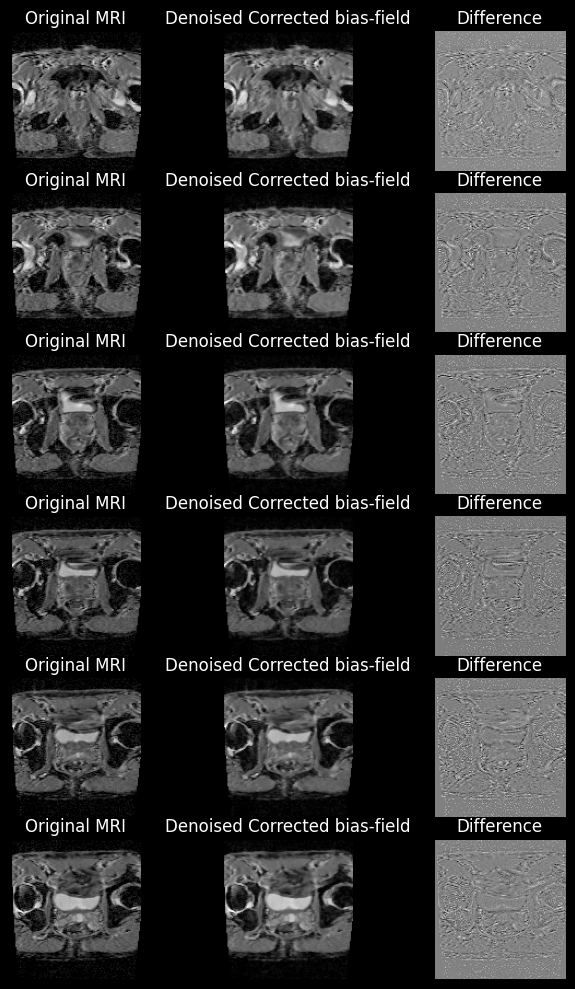

In [32]:
adc_denoised_image = sitk.CurvatureAnisotropicDiffusion(adc_bias_corrected_image, timeStep=0.03125)
plot_comparison(adc_bias_corrected_image, adc_denoised_image, title2="Denoised Corrected bias-field")

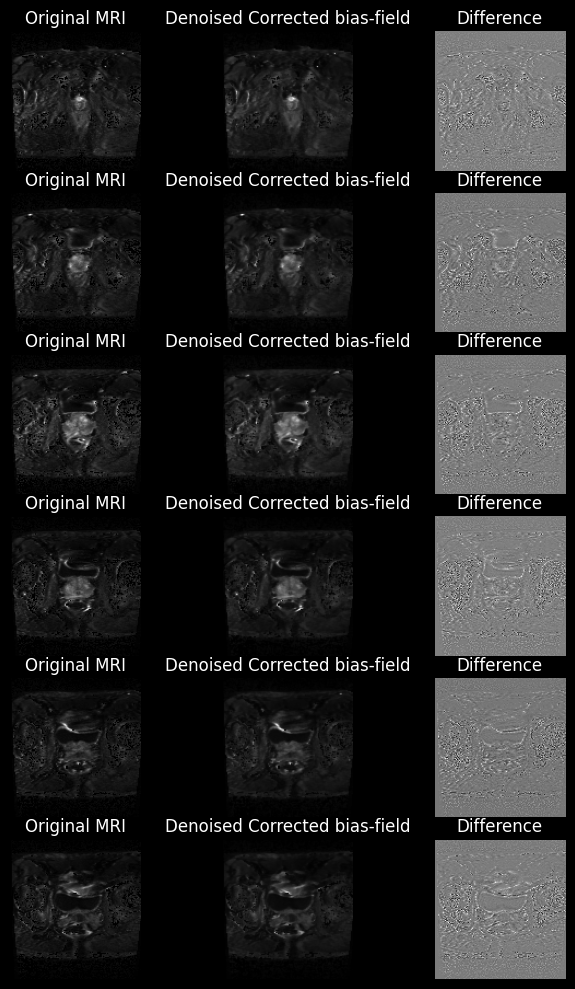

In [33]:
dwi_denoised_image = sitk.CurvatureAnisotropicDiffusion(dwi_bias_corrected_image, timeStep=0.03125)
plot_comparison(dwi_bias_corrected_image, dwi_denoised_image, title2="Denoised Corrected bias-field")